In [1]:
import pysd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import scipy.optimize

import os,time,datetime

from sko.PSO import PSO

%matplotlib inline

# System Dynamics Hospital Modelling For ICU

## 1. Data Prerequence and visualization

In [2]:
# Import model file
model_folder = os.getcwd()
file_name = 'Covid19.py'
# model_path = os.path.join(model_folder, file_name)
# model = pysd.read_vensim(model_path)
model_path = os.path.join(model_folder, file_name)
model = pysd.load(model_path)

# Import reality file
# import reality data from xlsx file:
excel_path = r'C:\\Users\\56474\\Desktop\\Learning\\DSA8030 Individual Industry Based Project\\Shu.xlsx'
real_time_data = pd.read_excel(excel_path,header=1)
real_time_data = real_time_data.dropna(subset=['Date'])
# real_time_data = real_time_data.set_index('Date')

D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_icu_admission
Casting delay order from 20.800000 to 21
  warnings.warn(


In [3]:
# We can see that the dataset has lots of missing values.
# Because it will lost the trend, we cannot delete the data simply.
# Here, we use KNN-means to fill the missing values.

# Create KNN method that uses to fill data 
# Also, we use machine learning to find the best values of n(the long of ceil)

def knn_means(n):
    filled_data = real_time_data
    for item in filled_data.columns:
        if not item == 'Date':
            input = filled_data[item]
            out = np.copy(filled_data[item])
            for i, val in enumerate(input):
                if np.isnan(val):
                    n_by_2 = np.ceil(n/2)
                    lower = np.max([0, int(i-n_by_2)])
                    upper = np.min([len(input)+1, int(i+n_by_2)])
                    data_near = np.concatenate([input[lower:i], input[i:upper]])
                    out[i] = np.nanmean(data_near)
            
            filled_data[item] = out

    return filled_data


In [4]:
# for item in real_time_data.columns:
#     print(item)

filled_data = knn_means(10)
filled_data

<ipython-input-3-f0762c3e2ef7>:20: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(data_near)


,Date,Cases,Bed Occupancy,Respiratory Support,ICU,Infectivity,Admissions
0,2021-03-01,0.0,86.0,17.0,37.0,0.171424,7.0
1,2021-03-02,0.0,86.0,12.0,37.0,0.171424,4.0
2,2021-03-03,0.0,81.0,7.0,34.0,0.171424,2.0
3,2021-03-04,0.0,72.0,6.0,32.0,0.171424,3.0
4,2021-03-05,0.0,58.0,8.0,31.0,0.171424,3.0
...,...,...,...,...,...,...,...
261,2021-11-17,276.0,89.0,10.0,36.0,0.172635,5.0
262,2021-11-18,299.0,88.0,16.0,35.0,0.172652,4.0
263,2021-11-19,312.0,87.0,16.0,34.0,0.172670,2.0
264,2021-11-20,251.0,87.0,14.2,36.0,0.172687,NaN


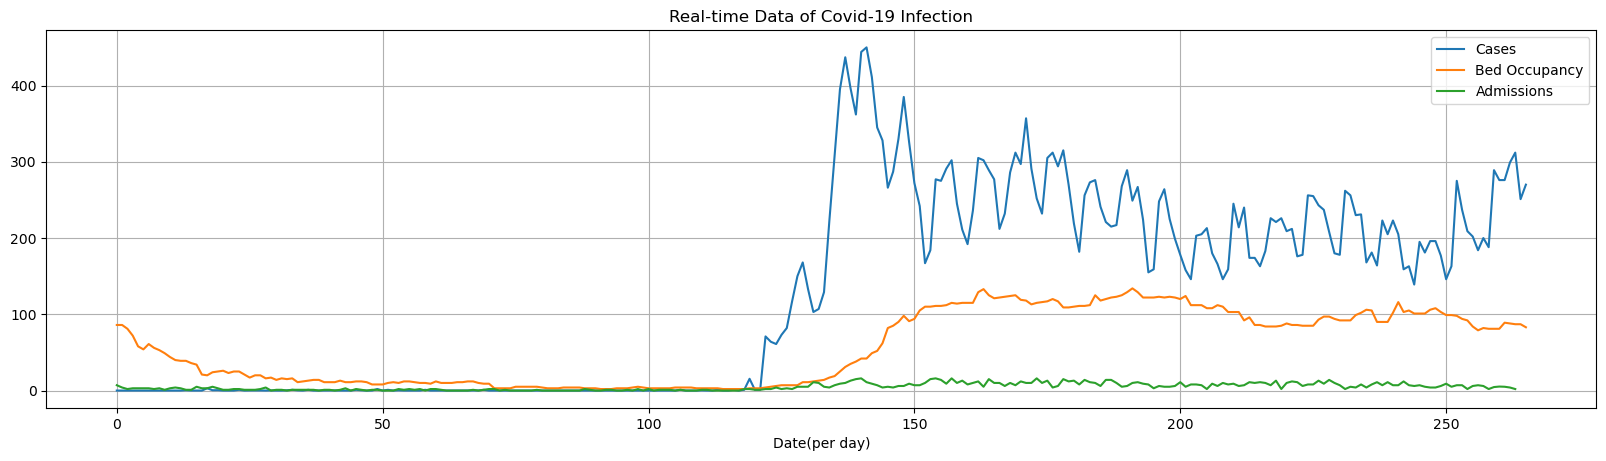

In [5]:
# Plotting reality data
plt.figure(figsize=(20,5), dpi=100)
plt.plot(real_time_data.index, real_time_data['Cases'])
plt.plot(real_time_data.index, real_time_data['Bed Occupancy']) 
plt.plot(real_time_data.index, real_time_data['Admissions']) 
plt.gca().set(title='Real-time Data of Covid-19 Infection', xlabel='Date(per day)')
plt.grid()
plt.legend(['Cases', 'Bed Occupancy','Admissions'])
plt.show()

Observing the image, we can see that from 2021-03-01 to 2021-06-30:
1. Case data is distributed in [0,1].
2. Admissions data has no obvious fluctuations, and the image performance is very flat.
3. Bed Occupancy began to decline from the highest point (86.0), and there has been no upward trend until the end of this period.
4. The missing data rate is 25.5%.

Data from 2021-07-01 to the end:
1. Case data rose significantly.
2. There are some missing data (missing rate is less than 5% and most of them are concentrated on weekends).
3. Bed Occupancy starts to rise.

Therefore, from the analysis of the above two periods, it is obvious that:
1. The data can clearly distinguish the non-epidemic period and the epidemic period of Covid-19.
2. The data in the non-epidemic period is not helpful for us to predict the medical resources during the epidemic period, and there are many missing data. Completing the data will affect the overall trend.
3. There is a certain lack of data during the Covid-19 pandemic, and the data image can be smoothed in the form of completion.

In [6]:
# Observing the data shows that there are large-scale missing data from March to June (the missing rate is 25.5%), and the data distribution interval is [0,1]
# So before cleaning up the model, use complete data for simulation
real_time_data_Jul2End = real_time_data[real_time_data.index > 120].reset_index(drop=True)
real_time_data_Jul2End = real_time_data_Jul2End.dropna(subset=['Admissions'])
real_time_data_Jul2End

,Date,Cases,Bed Occupancy,Respiratory Support,ICU,Infectivity,Admissions
0,2021-06-30,1.0,3.0,0.000,2.000,0.174536,1.00
1,2021-07-01,71.0,4.0,1.000,2.000,0.174536,2.00
2,2021-07-02,64.0,5.0,1.000,4.000,0.174536,2.00
3,2021-07-03,61.0,6.0,0.875,3.875,0.174536,4.00
4,2021-07-04,73.0,7.0,1.125,4.125,0.174536,2.00
...,...,...,...,...,...,...,...
138,2021-11-15,289.0,81.0,13.000,41.000,0.172601,4.60
139,2021-11-16,276.0,81.0,16.000,38.000,0.172618,5.25
140,2021-11-17,276.0,89.0,10.000,36.000,0.172635,5.00
141,2021-11-18,299.0,88.0,16.000,35.000,0.172652,4.00


In [7]:
# Here we need to import reality data to this model
# reality.cases_data -> init_model.cases_data
# reality.admissions_data -> init_model.admissions_data
init_model = model
init_model.set_components({
    'cases data': real_time_data_Jul2End['Cases'],
    'admissions data': real_time_data_Jul2End['Admissions'],
    'infectivity': real_time_data_Jul2End['Infectivity']
})

# Run model by initial parameters (Use range as same as dataset that be simulated)
init_sim = init_model.run(return_timestamps=range(0,real_time_data_Jul2End.shape[0]))
# Change index to date
# init_model['datetime'] = pd.date_range(start="2021-01-01", end="2021-12-31")
# init_model = init_model.set_index('datetime')
print('This dataset has ' + str(init_sim.shape[0]) + ' cols and ' + str(init_sim.shape[1]) + ' rows')

This dataset has 143 cols and 52 rows


D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_icu_admission
Casting delay order from 20.800000 to 21
  warnings.warn(


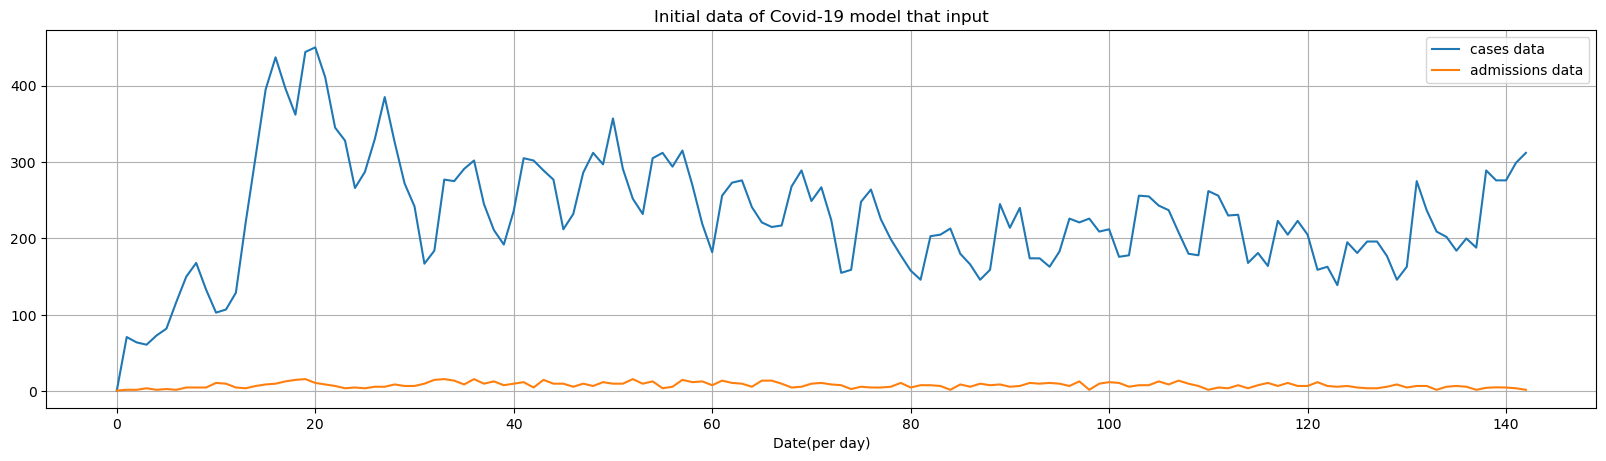

In [8]:
# Plotting Output after using initial parameters
plt.figure(figsize=(20,5), dpi=100)
plt.plot(init_sim.index, init_sim['cases data'])
# plt.plot(init_sim.index, init_sim['occupancy data']) 
plt.plot(init_sim.index, init_sim['admissions data']) 
plt.gca().set(title='Initial data of Covid-19 model that input', xlabel='Date(per day)')
plt.grid()
plt.legend(['cases data','admissions data'])
plt.show()

In [9]:
# define SSE function of model
max_range = real_time_data_Jul2End.shape[0]
print(max_range)
def SSE_calc(param_list):
    # Get parameters from param_list
    AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB = param_list

    # Using parameters that got above to run model
    optim_sim = init_model.run(
        return_timestamps=range(0,max_range),
        params={
        'average_contacts': AC,
        'delay_before_symptoms': DBS,
        'fraction_requiring_admission': FRA,
        'time_before_hospitalisation': TBH,
        'attendance_factor_above_testing': AFAT,
        'fraction_on_respiratory_support': FoRS,
        'no_icu_length_of_stay': nILoS,
        'fraction_admitted_to_icu': FAI,
        'fraction_entering_rehab': FER,
        'icu_length_of_stay': ILoS,
        'length_of_stay_in_interim_bed': LoSIB
        }
    )
    
    # Calculate the sum of the squared errors
    # print(optim_sim['total occupancy'])
    res = sum(
        optim_sim['total occupancy'] - real_time_data_Jul2End['Bed Occupancy']
        ) ** 2 + sum(
            optim_sim['ICU'] - real_time_data_Jul2End['ICU']
            ) ** 2 + sum(
                optim_sim['number on respiratory support'] - real_time_data_Jul2End['Respiratory Support']
                ) ** 2
    # res = sum(optim_sim['total occupancy'] - real_time_data_Jul2End['Bed Occupancy']) ** 2

    # res = mean_squared_error(
    #     real_time_data_Jul2End['ICU'], 
    #     model_after_optim['ICU']
    #     ) + mean_squared_error(
    #         real_time_data_Jul2End['Bed Occupancy'], 
    #         model_after_optim['total occupancy']
    #         ) + mean_squared_error(
    #             real_time_data_Jul2End['Respiratory Support'], 
    #             model_after_optim['number on respiratory support']
    #             )

    # If you want to see the process of calculating, just use the following code.
    # print('now input params are: ', AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB)
    # print('Calc: ', res)
    return(res)

143


In [10]:
# Set initial values and bounds
AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB = [5.8, 1, 0.1, 3, 1, 0.15, 10, 0.1, 0.1, 9, 14]

AC_bounds, DBS_bounds, FRA_bounds, TBH_bounds, AFAT_bounds, FoRS_bounds, nILoS_bounds, FAI_bounds, FER_bounds, ILoS_bounds, LoSIB_bounds = [(0.0001,10)] * 11

In [11]:
# Running optim method
res = scipy.optimize.minimize(SSE_calc, 
                              [AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB],
                              method='L-BFGS-B',
                              bounds=[
                                  AC_bounds, 
                                  DBS_bounds, 
                                  FRA_bounds, 
                                  TBH_bounds, 
                                  AFAT_bounds, 
                                  FoRS_bounds, 
                                  nILoS_bounds, 
                                  FAI_bounds, 
                                  FER_bounds, 
                                  ILoS_bounds, 
                                  LoSIB_bounds
                                  ],
                                tol=0.00001
                            #   options = {
                            #       'disp': False,
                            #       'xtol': 0.0001,
                            #       'ftol': 0.0001
                            #        }
                                  )

D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_icu_admission
Casting delay order from 20.800000 to 21
  warnings.warn(
D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_going_to_hospital
Casting delay order from 48.000000 to 48
  warnings.warn(
D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_discharge_from_hospital
Casting delay order from 160.000000 to 160
  warnings.warn(
D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_exiting_icu_bed
Casting delay order from 144.000000 to 144
  warnings.warn(
D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\statefuls.py:319: UserWarning: _delayfixed_discharge_from_intermediate_service
Casting delay order from 160.000000 to 160
  warnings.warn(
D:\Development\ENV\Anaconda3\lib\site-packages\pysd\py_backend\sta

## 3. Result and Visualization

In [31]:
# Show the results of the parameters after calibration
optim_res = res.x
AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB = optim_res
optim_res_pd = np.append(optim_res, 'L-BFGS-B')
fitting_parameters_result = pd.DataFrame(
    [optim_res_pd,[5.8, 1, 0.1, 3, 1, 0.15, 10, 0.1, 0.1, 9, 14, 'Vensim']],
    columns=[
        'average_contacts',
        'delay_before_symptoms',
        'fraction_requiring_admission',
        'time_before_hospitalisation',
        'attendance_factor_above_testing',
        'fraction_on_respiratory_support',
        'no_icu_length_of_stay',
        'fraction_admitted_to_icu',
        'fraction_entering_rehab',
        'icu_length_of_stay',
        'length_of_stay_in_interim_bed',
        'Parameters'
        ]
    )
fitting_parameters_result = fitting_parameters_result.set_index('Parameters')
fitting_parameters_result = fitting_parameters_result.T
fitting_parameters_result['L-BFGS-B'] = fitting_parameters_result['L-BFGS-B'].astype('float64')
fitting_parameters_result['Vensim'] = fitting_parameters_result['Vensim'].astype('float64')
fitting_parameters_result['Diff'] = fitting_parameters_result['L-BFGS-B'] - fitting_parameters_result['Vensim']
fitting_parameters_result['Percentage'] = fitting_parameters_result['Diff'] / fitting_parameters_result['Vensim']
fitting_parameters_result['Percentage'] = fitting_parameters_result['Percentage'].apply(lambda x: format(x, '.2%')) 
fitting_parameters_result

Parameters,L-BFGS-B,Vensim,Diff,Percentage
average_contacts,5.800000,5.80,0.000000,0.00%
delay_before_symptoms,1.000000,1.00,0.000000,0.00%
fraction_requiring_admission,0.008756,0.10,-0.091244,-91.24%
time_before_hospitalisation,3.000000,3.00,0.000000,0.00%
attendance_factor_above_testing,3.726415,1.00,2.726415,272.64%
fraction_on_respiratory_support,0.425290,0.15,0.275290,183.53%
no_icu_length_of_stay,10.000000,10.00,0.000000,0.00%
fraction_admitted_to_icu,0.541904,0.10,0.441904,441.90%
fraction_entering_rehab,0.100000,0.10,0.000000,0.00%
icu_length_of_stay,9.000000,9.00,0.000000,0.00%


From the result above:  
There is no or a few difference between optimization values and initial values:
- average_contacts
- delay_before_symptoms
- time_before_hospitalisation
- no_icu_length_of_stay
- fraction_entering_rehab
- icu_length_of_stay

And the parameters which have slightly changes (The absolute value of the percentage change is less than 50%):
- length_of_stay_in_interim_bed

And the parameters which have huge changes:
- fraction_requiring_admission
- attendance_factor_above_testing
- fraction_on_respiratory_support
- fraction_admitted_to_icu

In [14]:
# Here we get the values after optimization
# optim_res = res.x
# AC, DBS, FRA, TBH, AFAT, FoRS, nILoS, FAI, FER, ILoS, LoSIB = optim_res

model_after_optim = init_model.run(
    return_timestamps=range(0,real_time_data_Jul2End.shape[0]),
    params={
    'average_contacts': AC,
    'delay_before_symptoms': DBS,
    'fraction_requiring_admission': FRA,
    'time_before_hospitalisation': TBH,
    'attendance_factor_above_testing': AFAT,
    'fraction_on_respiratory_support': FoRS,
    'no_icu_length_of_stay': nILoS,
    'fraction_admitted_to_icu': FAI,
    'fraction_entering_rehab': FER,
    'icu_length_of_stay': ILoS,
    'length_of_stay_in_interim_bed': LoSIB
    }
)

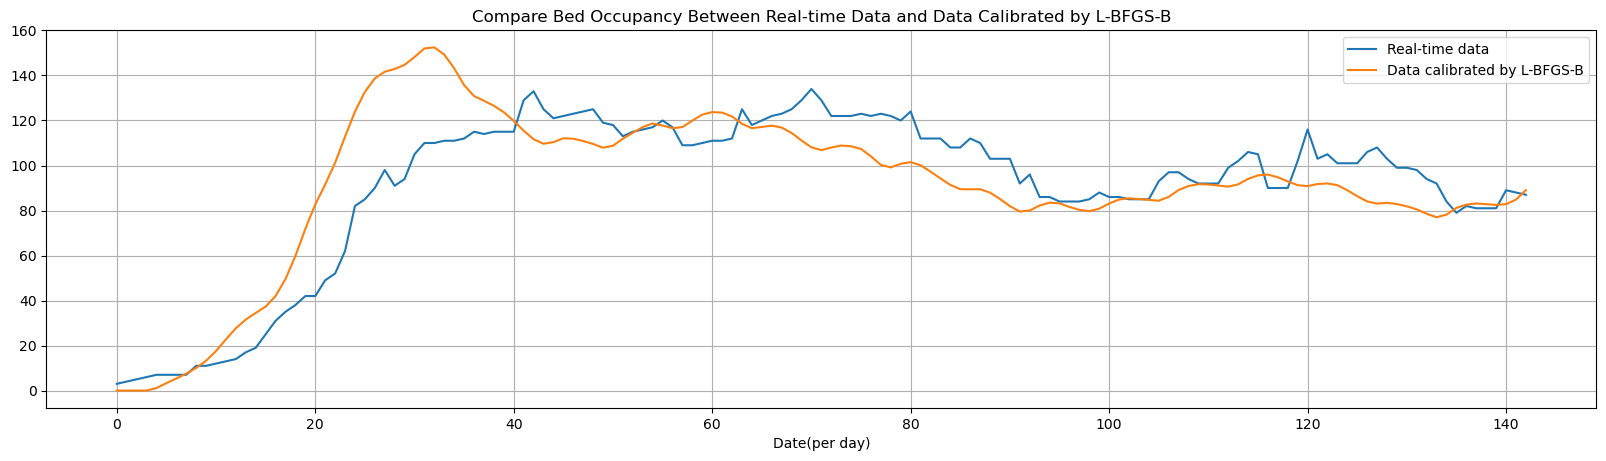

In [19]:
# Compare plot
# First, we compare fitting data to the reality data
plt.figure(figsize=(20,5), dpi=100)
plt.plot(real_time_data_Jul2End.index, real_time_data_Jul2End['Bed Occupancy'])
# plt.plot(init_sim.index, init_sim['occupancy data']) 
plt.plot(model_after_optim.index, model_after_optim['total occupancy']) 
plt.gca().set(title='Compare Bed Occupancy Between Real-time Data and Data Calibrated by L-BFGS-B', xlabel='Date(per day)')
plt.grid()
plt.legend(['Real-time data', 'Data calibrated by L-BFGS-B'])
plt.show()

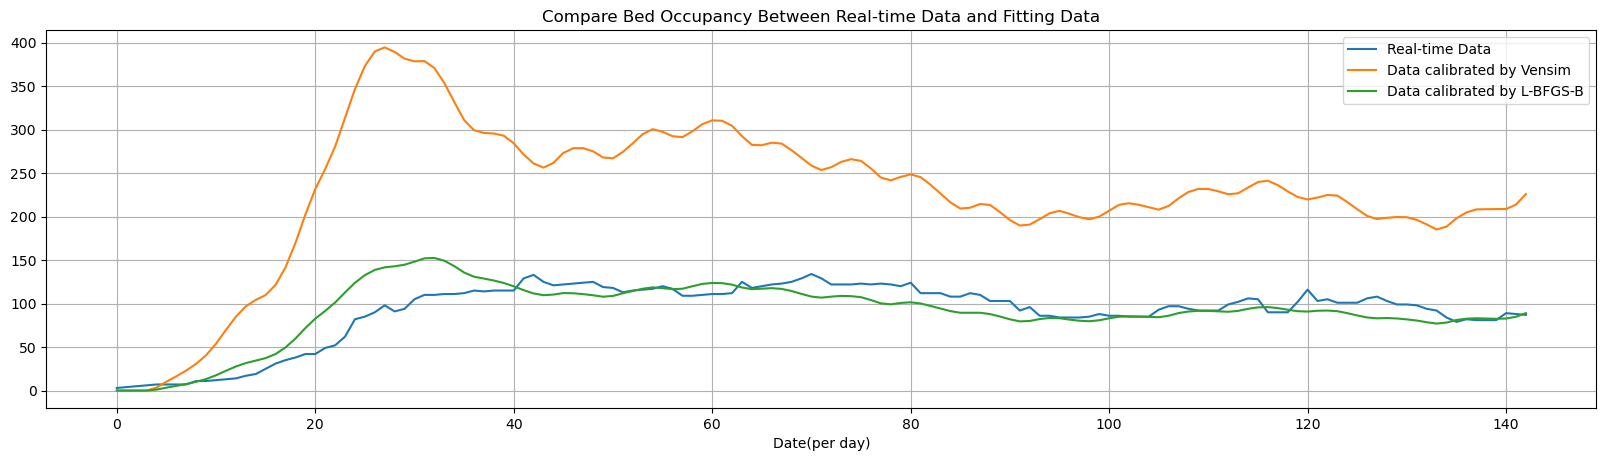

In [20]:
# From the plot above, we can see that the two lines are closely.
# Here we add a lines that the trend of initial data of the model's settings
plt.figure(figsize=(20,5), dpi=100)
plt.plot(real_time_data_Jul2End.index, real_time_data_Jul2End['Bed Occupancy'])
plt.plot(init_sim.index, init_sim['total occupancy'])
# plt.plot(init_sim.index, init_sim['occupancy data']) 
plt.plot(model_after_optim.index, model_after_optim['total occupancy']) 
plt.gca().set(title='Compare Bed Occupancy Between Real-time Data and Fitting Data', xlabel='Date(per day)')
plt.grid()
plt.legend(['Real-time Data', 'Data calibrated by Vensim', 'Data calibrated by L-BFGS-B'])
plt.show()

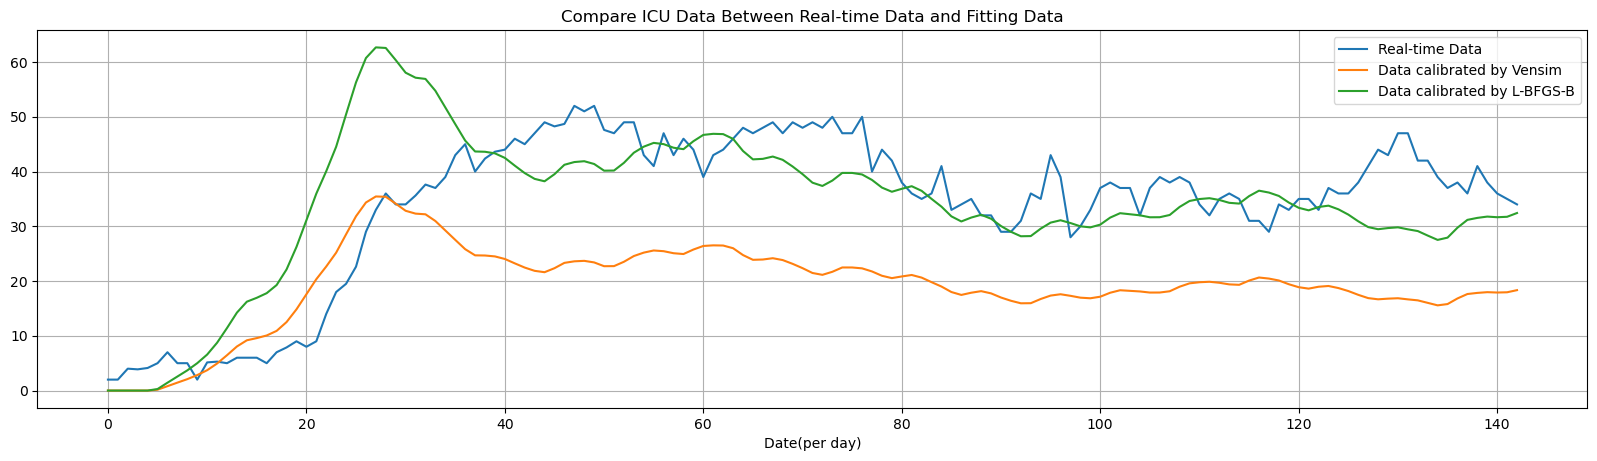

In [21]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(real_time_data_Jul2End.index, real_time_data_Jul2End['ICU'])
plt.plot(init_sim.index, init_sim['ICU'])
# plt.plot(init_sim.index, init_sim['occupancy data']) 
plt.plot(model_after_optim.index, model_after_optim['ICU']) 
plt.gca().set(title='Compare ICU Data Between Real-time Data and Fitting Data', xlabel='Date(per day)')
plt.grid()
plt.legend(['Real-time Data', 'Data calibrated by Vensim', 'Data calibrated by L-BFGS-B'])
plt.show()

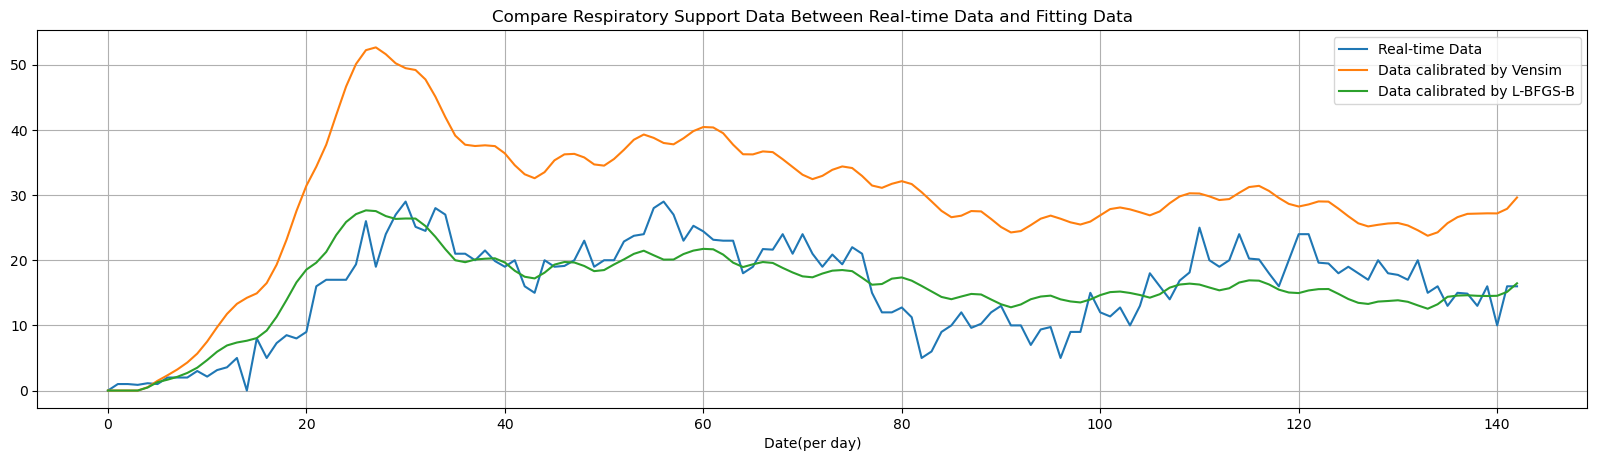

In [22]:
plt.figure(figsize=(20,5), dpi=100)
plt.plot(real_time_data_Jul2End.index, real_time_data_Jul2End['Respiratory Support'])
plt.plot(init_sim.index, init_sim['number on respiratory support'])
# plt.plot(init_sim.index, init_sim['occupancy data']) 
plt.plot(model_after_optim.index, model_after_optim['number on respiratory support']) 
plt.gca().set(title='Compare Respiratory Support Data Between Real-time Data and Fitting Data', xlabel='Date(per day)')
plt.grid()
plt.legend(['Real-time Data', 'Data calibrated by Vensim', 'Data calibrated by L-BFGS-B'])
plt.show()

In [ ]:
# Calculate RMSE and R^2

# optim_MSE = mean_squared_error(real_time_data_Jul2End['Bed Occupancy'], model_after_optim['total occupancy'])
bed_occupancy_optim_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['Bed Occupancy'], model_after_optim['total occupancy']))
bed_occupancy_optim_R_square = r2_score(real_time_data_Jul2End['Bed Occupancy'], model_after_optim['total occupancy'])

ICU_optim_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['ICU'], model_after_optim['ICU']))
ICU_optim_R_square = r2_score(real_time_data_Jul2End['ICU'], model_after_optim['ICU'])

respiratory_support_optim_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['Respiratory Support'], model_after_optim['number on respiratory support']))
respiratory_support_optim_R_square = r2_score(real_time_data_Jul2End['Respiratory Support'], model_after_optim['number on respiratory support'])

print('RMSE:')
print('    Bed Occupancy: ', bed_occupancy_optim_RMSE)
print('    ICU: ', ICU_optim_RMSE)
print('    Respiratory Support: ', respiratory_support_optim_RMSE)
print('Test R^2:')
print('    Bed Occupancy: ', bed_occupancy_optim_R_square)
print('    ICU: ', ICU_optim_R_square)
print('    Respiratory Support: ', respiratory_support_optim_R_square)

RMSE:
    Bed Occupancy:  18.742928776146627
    ICU:  10.583958716043194
    Respiratory Support:  4.166991783788456
Test R^2:
    Bed Occupancy:  0.7070489945928287
    ICU:  0.4201159812983274
    Respiratory Support:  0.6693654070130098


In [ ]:
# Also we should calculate MSE,RMSE,R^2 of Sarah's Model
bed_occupancy_init_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['Bed Occupancy'], init_sim['total occupancy']))
bed_occupancy_init_R_square = r2_score(real_time_data_Jul2End['Bed Occupancy'], init_sim['total occupancy'])

ICU_init_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['ICU'], init_sim['ICU']))
ICU_init_R_square = r2_score(real_time_data_Jul2End['ICU'], init_sim['ICU'])

respiratory_support_init_RMSE = np.sqrt(mean_squared_error(real_time_data_Jul2End['Respiratory Support'], init_sim['number on respiratory support']))
respiratory_support_init_R_square = r2_score(real_time_data_Jul2End['Respiratory Support'], init_sim['number on respiratory support'],)

print('RMSE:')
print('    Bed Occupancy: ', bed_occupancy_init_RMSE)
print('    ICU: ', ICU_init_RMSE)
print('    Respiratory Support: ', respiratory_support_init_RMSE)
print('Test R^2:')
print('    Bed Occupancy: ', bed_occupancy_init_R_square)
print('    ICU: ', ICU_init_R_square)
print('    Respiratory Support: ', respiratory_support_init_R_square)

RMSE:
    Bed Occupancy:  148.75131452187097
    ICU:  17.9855429728024
    Respiratory Support:  15.019255126706813
Test R^2:
    Bed Occupancy:  -17.45192614865286
    ICU:  -0.6745262984930347
    Respiratory Support:  -3.2953622001104357


In [ ]:
# Draw RMSE and R^2 Plot
result = [
    ['Bed Occupancy',bed_occupancy_init_RMSE, bed_occupancy_optim_RMSE, bed_occupancy_init_R_square, bed_occupancy_optim_R_square],
    ['ICU Data',ICU_init_RMSE, ICU_optim_RMSE, ICU_init_R_square, ICU_optim_R_square],
    ['Respiratory Support',respiratory_support_init_RMSE, respiratory_support_optim_RMSE, respiratory_support_init_R_square, respiratory_support_optim_R_square],
    ]
fitting_results = pd.DataFrame(result, columns = ['row','RMSE before fitting', 'RMSE after fitting', 'r2_score before fitting', 'r2_score after fitting'])

fitting_results = fitting_results.set_index('row')
fitting_results

,RMSE before fitting,RMSE after fitting,r2_score before fitting,r2_score after fitting
row,,,,
Bed Occupancy,148.751315,18.742929,-17.451926,0.707049
ICU Data,17.985543,10.583959,-0.674526,0.420116
Respiratory Support,15.019255,4.166992,-3.295362,0.669365
